# Customer Assignment Problem

## Objective and Prerequisites

Sharpen your mathematical optimization modeling skills with this example, in which you will learn how to select the location of facilities based on their proximity to customers. We’ll demonstrate how you can construct a mixed-integer programming (MIP) model of this facility location problem, implement this model in the Gurobi Python API, and generate an optimal solution using the Gurobi Optimizer.

This modeling example is at the intermediate level, where we assume that you know Python and are familiar with the Gurobi Python API. In addition, you should have some knowledge about building mathematical optimization models.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

**Gurobi License** <br /> 
In order to run this Jupyter Notebook properly, you must have a Gurobi license. If you do not have one, you can request an [evaluation license](https://www.gurobi.com/downloads/request-an-evaluation-license/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-LOG-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_customer-assignment_COM_EVAL_GITHUB_&utm_term=customer-assignment-problem&utm_content=C_JPM) as a *commercial user*, or download a [free license](https://www.gurobi.com/academia/academic-program-and-licenses/?utm_source=3PW&utm_medium=OT&utm_campaign=WW-MU-LOG-OR-O_LEA-PR_NO-Q3_FY20_WW_JPME_customer-assignment_ACADEMIC_EVAL_GITHUB_&utm_term=customer-assignment-problem&utm_content=C_JPM) as an *academic user*.

---
## Motivation

Many companies in various industries must, at some point, make strategic decisions about where to build facilities to support their operations. For example:

- Producers of goods need to decide how to design their supply chains – which encompass factories, distribution centers, warehouses, and retail stores.
- Healthcare providers need to determine where to build hospitals to maximize their population coverage.

These are strategic decisions that are difficult to implement and costly to change because they entail long-term investments. Furthermore, these decisions have a significant impact, both in terms of customer satisfaction and cost management. One of the critical factors to consider in this process is the location of the customers that the company is planning to serve.

---
## Problem Description

The Customer Assignment Problem is closely related to the Facility Location Problem, which is concerned with the optimal placement of facilities (from a set of candidate locations) in order to minimize the distance between the company's facilities and the customers. When the facilities have unlimited capacity, customers are assumed to be served by the closest facility. 

In cases where the number of customers considered is too big, the customers can be grouped into clusters. Then, the cluster centers can be used in lieu of the individual customer locations. This pre-processing makes the assumption that all customers belonging to a given cluster will be served by the facility assigned to that cluster. The k-means algorithm can be used for this task, which aims to partition $n$ objects into $k$ distinct and non-overlapping clusters.

---
## Solution Approach

Mathematical optimization is a declarative approach where the modeler formulates a mathematical optimization model that captures the key aspects of a complex decision problem. The Gurobi Optimizer solves such models using state-of-the-art mathematics and computer science. 

A mathematical optimization model has five components, namely:

- Sets and indices.
- Parameters.
- Decision variables.
- Objective function(s).
- Constraints.

We now present a Binary Integer Programming (BIP) formulation:

### Sets and Indices
$i \in I$: Set of customer clusters.

$j \in J$: Set of potential facility locations.

$\text{Pairings}= \{(i,j) \in I \times J: \text{dist}_{i,j} \leq \text{threshold}\}$: Set of allowed pairings

### Parameters
$\text{threshold} \in \mathbb{R}^+$: Maximum distance for a cluster-facility pairing to be considered.

$\text{max_facilities} \in \mathbb{N}$: Maximum number of facilities to be opened.

$\text{weight}_i \in \mathbb{N}$: Number of customers in cluster $i$.

$\text{dist}_{i,j} \in \mathbb{R}^+$: Distance from cluster $i$ to facility location $j$.

### Decision Variables
$\text{select}_j \in \{0,1\}$: 1 if facility location $j$ is selected; 0 otherwise.

$\text{assign}_{i,j} \in \{0,1\}$: 1 if cluster $i$ is assigned to facility location $j$; 0 otherwise.

### Objective Function

- **Total distance**: Minimize the total distance from clusters to their assigned facility:

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}\text{weight}_i \cdot \text{dist}_{i,j} \cdot \text{assign}_{i,j}
\tag{0}
\end{equation}

### Constraints

- **Facility limit**: The number of facilities built cannot exceed the limit:

\begin{equation}
\sum_{j}\text{select}_j \leq \text{max_facilities}
\tag{1}
\end{equation}

- **Open to assign**: Cluster $i$ can only be assigned to facility $j$ if we decide to build that facility:

\begin{equation}
\text{assign}_{i,j} \leq \text{select}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **Closest store**: Cluster $i$ must be assigned to exactly one facility:

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{assign}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}

---
## Python Implementation

### Dataset Generation

In this simple example, we choose random locations for customers and facility candidates. Customers are distributed using Gaussian distributions around a few randomly chosen population centers, whereas facility locations are uniformly distributed.

In [1]:
%matplotlib inline
import random

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Tested with Gurobi v9.0.0 and Python 3.7.0

seed = 10101
num_customers = 50000
num_candidates = 50
max_facilities = 8
num_clusters = 1000
num_gaussians = 10
threshold = 0.99

random.seed(seed)
customers_per_gaussian = np.random.multinomial(num_customers,
                                               [1/num_gaussians]*num_gaussians)
customer_locs = []
for i in range(num_gaussians):
    # each center coordinate in [-0.5, 0.5]
    center = (random.random()-0.5, random.random()-0.5)
    customer_locs += [(random.gauss(0,.1) + center[0], random.gauss(0,.1) + center[1])
                  for i in range(customers_per_gaussian[i])]
# each candidate coordinate in [-0.5, 0.5]
facility_locs = [(random.random()-0.5, random.random()-0.5)
              for i in range(num_candidates)]
print('First customer location:', customer_locs[0])

First customer location: (0.33164437091949245, -0.2809884943538464)


### Preprocessing
**Clustering**

To limit the size of the optimization model, we group individual customers into clusters and optimize on these clusters. Clusters are computed using the K-means algorithm, as implemented in the scikit-learn package.

In [2]:
kmeans = MiniBatchKMeans(n_clusters=num_clusters, init_size=3*num_clusters,
                         random_state=seed).fit(customer_locs)
memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_) # Center point for each cluster
weights = list(np.histogram(memberships, bins=num_clusters)[0]) # Number of customers in each cluster
print('First cluster center:', centroids[0])
print('Weights for first 10 clusters:', weights[:10])

First cluster center: [ 0.41682515 -0.38402675]
Weights for first 10 clusters: [56, 56, 78, 104, 84, 34, 55, 24, 54, 44]


***Viable Customer-Store Pairings***

Some facilities are just too far away from a cluster center to be relevant, so let's heuristically filter all distances that exceed a given `threshold`:

In [3]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1-loc2, ord=2) # Euclidean distance

pairings = {(facility, cluster): dist(facility_locs[facility], centroids[cluster])
            for facility in range(num_candidates)
            for cluster in range(num_clusters) 
            if  dist(facility_locs[facility], centroids[cluster]) < threshold}
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 48897


###  Model Deployment

Build facilities from among candidate locations to minimize total distance to cluster centers:

In [4]:
m = gp.Model("Facility location")

# Decision variables: select facility locations
select = m.addVars(range(num_candidates), vtype=GRB.BINARY, name='select')
# Decision variables: assign customer clusters to a facility location
assign = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='assign')

# Deploy Objective Function
# 0. Total distance
obj = gp.quicksum(weights[cluster]
               *pairings[facility, cluster]
               *assign[facility, cluster]
               for facility, cluster in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. Facility limit
m.addConstr(select.sum() <= max_facilities, name="Facility_limit")

# 2. Open to assign
m.addConstrs((assign[facility, cluster] <= select[facility]
             for facility, cluster in pairings.keys()),
            name="Open2assign")

# 3. Closest store
m.addConstrs((assign.sum('*', cluster) == 1
             for cluster in range(num_clusters)),
            name="Closest_store")

# Find the optimal solution
m.optimize()

Using license file c:\gurobi\gurobi.lic
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 49898 rows, 48947 columns and 146741 nonzeros
Model fingerprint: 0xe7ec775c
Variable types: 0 continuous, 48947 integer (48947 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve time: 0.21s
Presolved: 49898 rows, 48947 columns, 146741 nonzeros
Variable types: 0 continuous, 48947 integer (48947 binary)
Found heuristic solution: objective 8666.5999303

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.922779e+03, 6113 iterations, 1.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

## Analysis

Let's plot a map with:

- Customer locations represented as small pink dots.
- Customer cluster centroids represented as large red dots.
- Facility location candidates represented as green dots. Notice that selected locations have black lines emanating from them towards each cluster that is likely to be served by that facility.

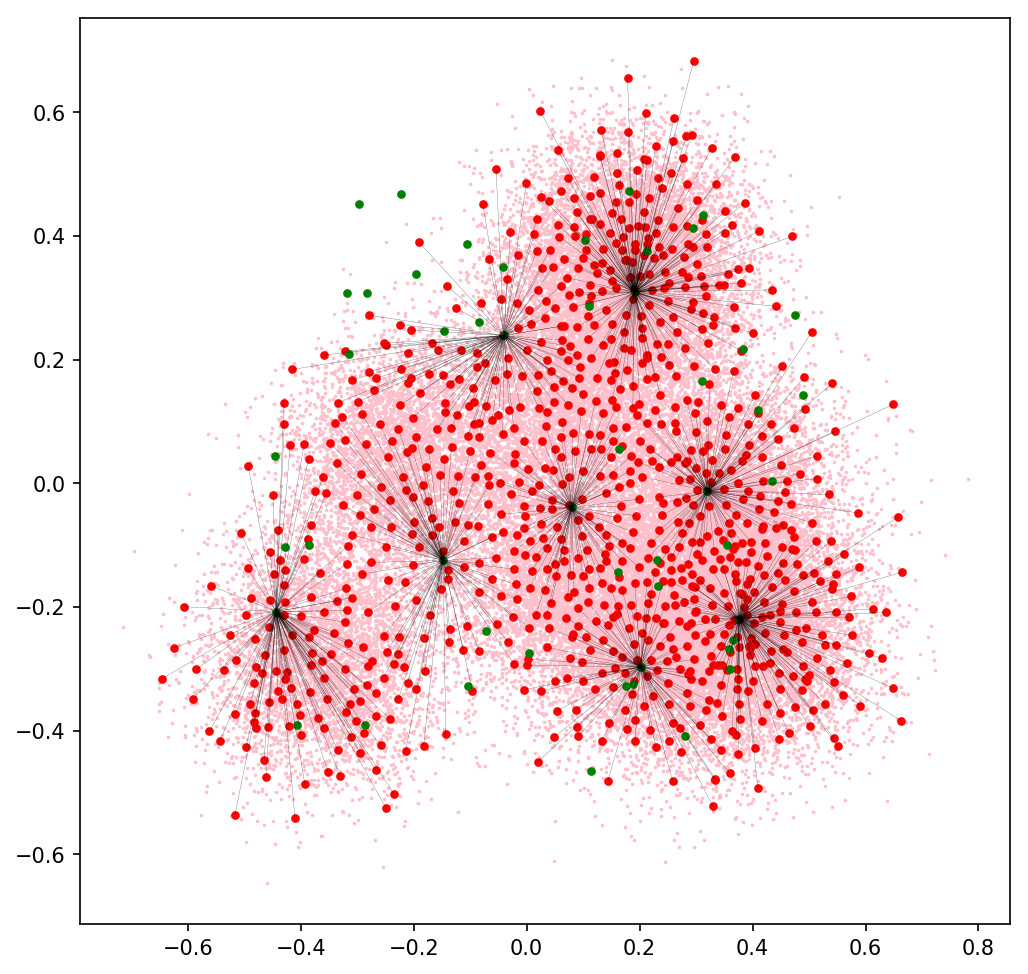

In [5]:
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(*zip(*customer_locs), c='Pink', s=0.5)
plt.scatter(*zip(*centroids), c='Red', s=10)
plt.scatter(*zip(*facility_locs), c='Green', s=10)
assignments = [p for p in pairings if assign[p].x > 0.5]
for p in assignments:
    pts = [facility_locs[p[0]], centroids[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

---
## Conclusions

We learned how mathematical optimization can be used to solve the Customer Assignment Problem. Moreover, it has been shown how machine learning can be used in the pre-processing so as to reduce the computational burden of big datasets. Of course, this comes at a cost, as using fewer clusters will result in coarser approximations to the global optimal solution.

---
## References

1. Drezner, Z., & Hamacher, H. W. (Eds.). (2001). Facility location: applications and theory. Springer Science & Business Media.
2. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
3. Klose, A., & Drexl, A. (2005). Facility location models for distribution system design. European journal of operational research, 162(1), 4-29.

Copyright © 2020 Gurobi Optimization, LLC